In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Short analysis of the biased run
Here we sample the following probability distribution

$$P(\mathbf{R}, \mathbf{\eta})\propto \exp{\{-\beta [U(\mathbf{R})+ \eta_1 V(s_1, t)+\eta_2 V(s_2, t)]\}}$$

In PBMetaD we have a different deposition rate law. We still want the rate to decrease whenever the bias becomes significant. 

$$\omega_1(t)=\omega_1\exp{\left(-\frac{V(s_1, t)}{k\Delta T}\right)}P(\mathbf{\eta}=(1 0)|\mathbf{R})$$

and 

$$\omega_2(t)=\omega_2\exp{\left(-\frac{V(s_2, t)}{k\Delta T}\right)}P(\mathbf{\eta}=(0 1)|\mathbf{R})$$

## O-Ca2+ distance as a function of time

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3772/225668197.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills_d1 = plumed.read_as_pandas("HILLS_d1")


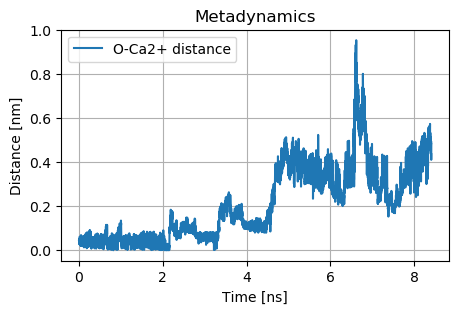

In [2]:
data_hills_d1 = plumed.read_as_pandas("HILLS_d1")
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_hills_d1["time"]*0.001, data_hills_d1["d1"], label="O-Ca2+ distance")
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")
plt.legend(loc="best")

# Coordination number as a function of time

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1320/1671903543.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills_coord = plumed.read_as_pandas("HILLS_coord")


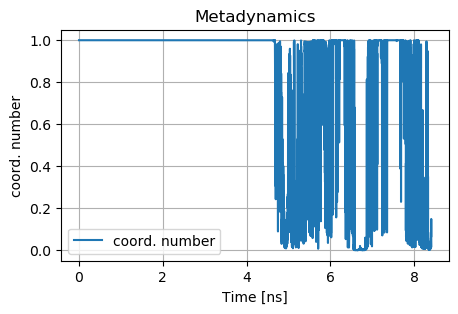

In [3]:
data_hills_coord = plumed.read_as_pandas("HILLS_coord")
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_hills_coord["time"]*0.001, data_hills_coord["coord"], label="coord. number")
plt.xlabel("Time [ns]")
plt.ylabel("coord. number")
plt.grid()
plt.title("Metadynamics")
plt.legend(loc="best")

## Biased and unbiased histograms as a function of O-Ca2+ distance
Here we consider the COLVAR file. Remember that the COLVAR file has more samples than the HILLS file. since the deposition PACE of the run is bigger than 100 (STRIDE for COLVAR). We expect the unbiased distribution to be very similar to the distribution of the first run without metadynamics. Be careful: always use $kT=1$ because plumed always expresses quantities multiplied by $\beta$. 

IMPORTANT: note that `sum_hills` is just summing the Gaussians to reconstruct the free energy as (proportional to) the applied potential.

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3772/3117451607.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar = plumed.read_as_pandas("COLVAR")


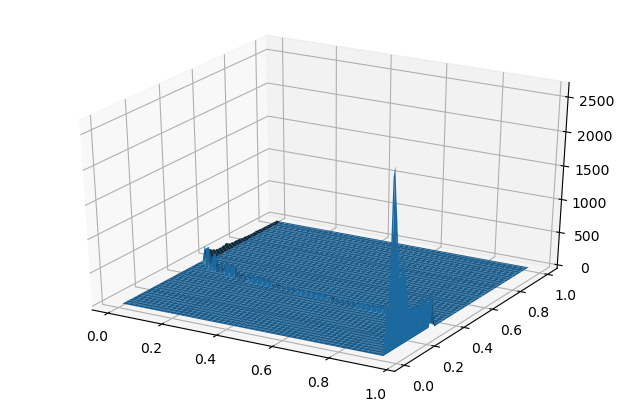

In [6]:
data_colvar = plumed.read_as_pandas("COLVAR")
val_bias, bins_bias_d1, bins_bias_coord = np.histogram2d(data_colvar["d1"], data_colvar["coord"], bins=100)
kT = 1
w = [math.exp(data_colvar["pbmetad.bias"][i])/kT for i in range(len(data_colvar["pbmetad.bias"]))]
val_unbias, bins_unbias_d1, bins_unbias_coord = np.histogram2d(data_colvar["d1"], data_colvar["coord"], bins=100, weights=w)

plt.rcParams["figure.figsize"] = (8, 5)

X = []
Y = []
h_d1 = bins_bias_d1[1] - bins_bias_d1[0]
h_coord = bins_bias_coord[1] - bins_bias_coord[0]
for i in range(len(bins_bias_d1) - 1):
    X.append(bins_bias_d1[i] + h_d1)
    Y.append(bins_bias_coord[i] + h_coord)

X, Y = np.meshgrid(X, Y)
Z = val_bias.reshape(X.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
# Note that len(bins_bias) = len(val_bias) + 1 because bins_bias contains the edges of the bins

# aggiusta gli RC params

In [8]:
def get_fes(bins, val):
    F = []
    s = []
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

In [9]:
F = []
dist = []
F, dist = get_fes(bins_unbias_d1, val_unbias)

# From the fes.dat file (elaboration of the HILLS file, via sum_hills)
plt.plot(dist, F, 'r',label="reweighting using pbmetad.bias")
plt.grid()
plt.legend(loc="best")
plt.title("Reweighted reconstruction")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Free energy surface")

TypeError: only size-1 arrays can be converted to Python scalars

# Free energy difference as a function of time
This is another useful quantity to keep track of. First we have to identify two basins $A$ and $B$, then we keep track of the free energy difference:
$$\Delta F=-kT\log{\left\{\frac{P(A)}{P(B)}\right\}}$$
The two probabilities distribution are approximated by integrals of $\exp{\{-\beta F(s)\}}$ over the identified basins. 